In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Cylindrical Power Spectrum estimation with ps_eor

A dataset has been provided to test the cylindrical Power Spectrum (PS) estimation, Primary Beam (PB) and Point Spread Function (PSF) deconvolution, and the submission format. This dataset includes:
- bins_frequency.txt: list of frequency bins the image should be split into
- bins_kpar.txt and bins_kper.txt: adopted binning for k parallel and perpendicular
- TestDatasetTRUTH_166MHz-181MHz.data: "truth" PS between 166-181 MHz
- TestDataset.msn(w)_image.fits: EoR+noise+instrumental effects, natural (uniform) weightning
- TestDataset.msn(w)_psf.fits: PSF for the test dataset with natural (uniform) weighting


## First steps

Import modules and define path to files

In [2]:
import numpy as np
from ps_eor import psutil, datacube, pspec
import matplotlib.pyplot as plt
import astropy.units as u

In [3]:
path = "/mnt/scratch/Pcyl_test/"
image_n = "TestDataset.msn_image-005.fits"
image_w = "TestDataset.msw_image-003.fits"
psf_w = "TestDataset.msw_psf-001.fits"
psf_n = "TestDataset.msn_psf-004.fits"

The cosmological parameters needed for the estimation of the Power Spectrum (PS) are, for a flat universe: $H_0=100$, $\Omega_\Lambda=0.69036$ and $\Omega_m=0.30964$.

**ps_eor** uses the *Planck15* best fit, so it must be changed.

In [4]:
from astropy.cosmology import FlatLambdaCDM
new_cosmo = FlatLambdaCDM(H0=100, Om0=0.30964)

psutil.set_cosmology(new_cosmo)

## Plot truth PS

The "truth" PS has been computed on the noiseless and unconvolved EoR realisation. The result of the our estimation should be very similar, although not equal, to the "truth" PS.

The following cells read and plot the "truth" PS, with its corresponding bins:

In [5]:
truth = np.loadtxt(path+'TestDatasetTRUTH_166MHz-181MHz.data')
par_bins = np.loadtxt(path+'bins_kpar.txt')
per_bins = np.loadtxt(path+'bins_kper.txt')
print('truth shape='+str(truth.shape))
print('bins shape='+str(par_bins.shape)+str(per_bins.shape))
#print(truth)

truth shape=(10, 10)
bins shape=(10,)(10,)


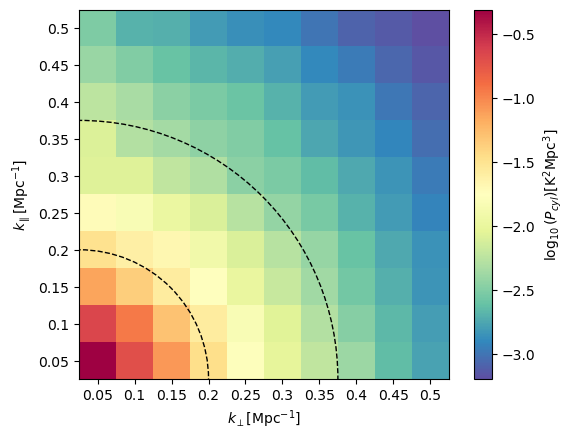

In [6]:
fig, ax = plt.subplots()
plt.axes(ax)
plt.imshow(np.log10(truth), origin='lower', cmap='Spectral_r') #note that imshow has transposed the x and y axis
plt.colorbar(label=r'$\log_{10}(P_{cyl})\mathrm{[K^{2}Mpc^{3}]}$')
plt.xlabel(r'$k_{\perp}\mathrm{[Mpc^{-1}]}$')
plt.ylabel(r'$k_{\parallel}\mathrm{[Mpc^{-1}]}$')
plt.xticks(np.arange(10),per_bins)
plt.yticks(np.arange(10),par_bins)
#plt.xlim(0,7)
#plt.ylim(0,7)
circ1 = plt.Circle((-0.5,-0.5), 3.5, fill=False, linestyle='--')
circ2 = plt.Circle((-0.5,-0.5), 7, fill=False, linestyle='--')
ax.add_patch(circ1)
ax.add_patch(circ2);

## Estimate PS from images

Here are some specifications needed for the next steps.

The simulations are of the SKA-Low radio interferometer. With `plotms()` of **CASA** we have seen that the baselines are:
- Min $= 37.4924 \mathrm{m} = 13.269\lambda$
- Max $= 73 508.6 \mathrm{m} = 26015.5\lambda$

Only the central 4x4 degrees are needed out of the 8x8 FoV

The simulation is of an observation of 4 hours, using a 10 second integration time. SDC3 data description (2.4)

Uniform weighting has better resolution so it is ideally better for the PS estimation, while natural weighting is better for point source cleaning. (??)

First, we run `datacube.load_from_fits_image_and_psf()`. What this function does is:
- Read the image and the PSF FITS files
- Trim image to required FoV
- Transform image (not PSF) from flux (Jy/beam) to brightness temperature (K). See Appendix A.
- Deconvolve PSF. Appendix A 
- Transform image and PSF to visibilities
- Can also apply a window function
- Return visibilities datacube with PSF as weights

In [7]:
#from visibilities in CASA: (in wavelengths)
min_b = 13.269
max_b = 26015.5

Seems like changing int_time and total_time does not affect the ressults

In [8]:
#time in seconds
data_cube = datacube.CartDataCube.load_from_fits_image_and_psf([path+image_n],
            [path+psf_n], min_b, max_b, np.deg2rad(4),
                    use_wscnormf=False, int_time=10, total_time=4*3600,
                    window_function=datacube.WindowFunction(('tukey', 0.2)))

 Progress: 1 / 1 (Total: 0.00 s) 
 Progress: 1 / 1 (Total: 0.00 s) 
Filtering 782471 modes (96.60 %)


Now that we have the cube in temperature and visibilities we can make the PS estimation. The next step is to define the $k$ bins. For the SDC3, there MUST be 10 bins of width 0.05 for each component to comply with the submission format, from 0.05 to 0.5 (these are the centres).

$k_{\perp}$ is the component on the spatial plane. To make the bins we define the array `el`, with `nbins_per` the number of bins within the range `binmin` and `binmax`. For this, we use the function `psutil.k_to_l()` and the redshift.

In [9]:
nbins_per = 10
binmin = 0.05
binmax = 0.5
z = psutil.freq_to_z((166+181)/2*1e6) # give in Hz
print(z)
el = psutil.k_to_l(np.linspace(binmin, binmax, nbins_per), z)
print(el)

7.18677636887608
[ 300.85414673  601.70829346  902.56244019 1203.41658692 1504.27073365
 1805.12488038 2105.97902711 2406.83317384 2707.68732057 3008.5414673 ]


$k_{\parallel}$ is the component along the line of sight, i.e. the frequency axis. We want the same bins as for $k_{\perp}$, but in this case, to obtain a reasonable estimation of the PS, we have to include all frequencies of the cube by calculating a higher $k_{\parallel}$. Therefore, we will calculate more bins than needed and then save just the ones we want.

The number of bins we will calculate is the same as the one we would get by using the frequencies of the data cube, which is obtained from the delays and the redshift.<br>
From that, we get the maximum $k_{\parallel}$ we need to calculate, which is the step (0.05) times the number of bins.<br>
Then, the width of the whole frequency band depends on the difference between delays and the wanted number of bins.<br>
Finally, a list with with `2*nbins+1` frequency bins is obtained.

In [10]:
#this is the number of bins we would get using the bins from data_cube.freqs
nbins_par = len(psutil.delay_to_k(psutil.get_delay(data_cube.freqs), z))-1 
binmin = 0.05 #starts here
binmax = 0.05*nbins_par #get more than 0.5 for better calculation
mfreq = (166+181) * 1e6 / 2  # in Hz
delay = psutil.k_to_delay(np.linspace(binmin, binmax, nbins_par), z)
fwidth = 2*nbins_par / ((delay[1]-delay[0])*(2*nbins_par+1))
freqbins = np.linspace(mfreq - fwidth/2, mfreq + fwidth/2, nbins_par*2+1)

Now, we can create a EoR window with those frequency bins.

In [11]:
eor = pspec.EorBin(1, freqbins, freqbins, M=len(freqbins))

To calculate the PS we have to configurate the estimator by giving the `el` array and choosing the window function and frequency delay transform method. We also have to create a primary beam object, in this case for SKA-Low, with antenna diameter = 38 m, alpha tapering = 1.02 and a Gaussian beam.

Then we include this in the PS generator `pspec.PowerSpectraCart()`.

In [12]:
ps_conf = pspec.PowerSpectraConfig(el, window_fct='blackmanharris')
pb = datacube.SkaLowPrimaryBeam()
ps_gen = pspec.PowerSpectraCart(eor, ps_conf, pb)

Finally, we calculate the Cylindrical PS with `pspec.PowerSpectraCart().get_ps2d()`. What this function does is the following:
- Make a slice of the data_cube to take the frequencies of the EoR window (`eor`)
- Get a normalization factor (`pspec.PowerSpectraCart().get_ps2d_norm()`)
- Get normalization factor for errors (`pspec.PowerSpectraCart().get_ps_err_norm()`)
- Transform data_cube to delays and get k bins (comoving coordinates) from delays and `el` with `psutil.delay_transform_cube()`
- Transform weights to delays
- calculate PS (Appendix B)

In [13]:
ps2d = ps_gen.get_ps2d(data_cube)

We can plot the power spectra with **ps_eor** (note that the y axis is inverted)

(74, 10)


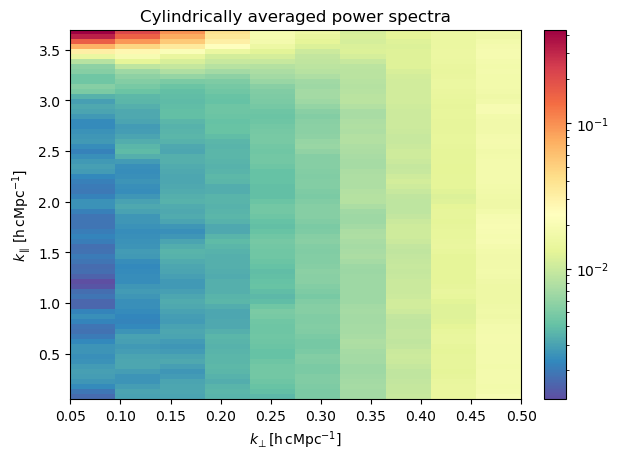

In [14]:
ps2d.plot(title='Cylindrically averaged power spectra', cmap='Spectral_r');
#plt.savefig('ps2d.pdf')
ps2d.save_to_txt('ps2d.txt')
print(ps2d.data.shape)

or with directly with **matplotlib**

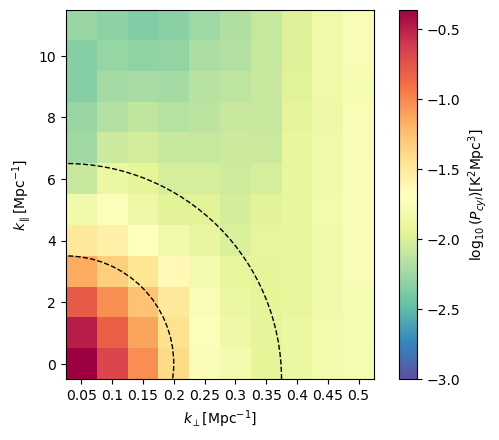

In [15]:
fig, ax = plt.subplots()
plt.axes(ax)
plt.imshow(np.log10(ps2d.data[:12]), origin='lower', cmap='Spectral_r', aspect=1, vmin=-3) #note that imshow has transposed the x and y axis
plt.colorbar(label=r'$\log_{10}(P_{cyl})\mathrm{[K^{2}Mpc^{3}]}$') #
plt.xlabel(r'$k_{\perp}\mathrm{[Mpc^{-1}]}$')
plt.ylabel(r'$k_{\parallel}\mathrm{[Mpc^{-1}]}$')
plt.xticks(np.arange(len(ps2d.k_per)),ps2d.k_per.round(2))
#plt.yticks(np.arange(len(ps2d.k_par)),ps2d.k_par.round(2))
#plt.xlim(0,12)
#plt.ylim(0,12)
circ1 = plt.Circle((-0.5,-0.), 3.5, fill=False, linestyle='--')
circ2 = plt.Circle((-0.5,-0.5), 7, fill=False, linestyle='--')
ax.add_patch(circ1)
ax.add_patch(circ2);

And we compare it to the truth PS

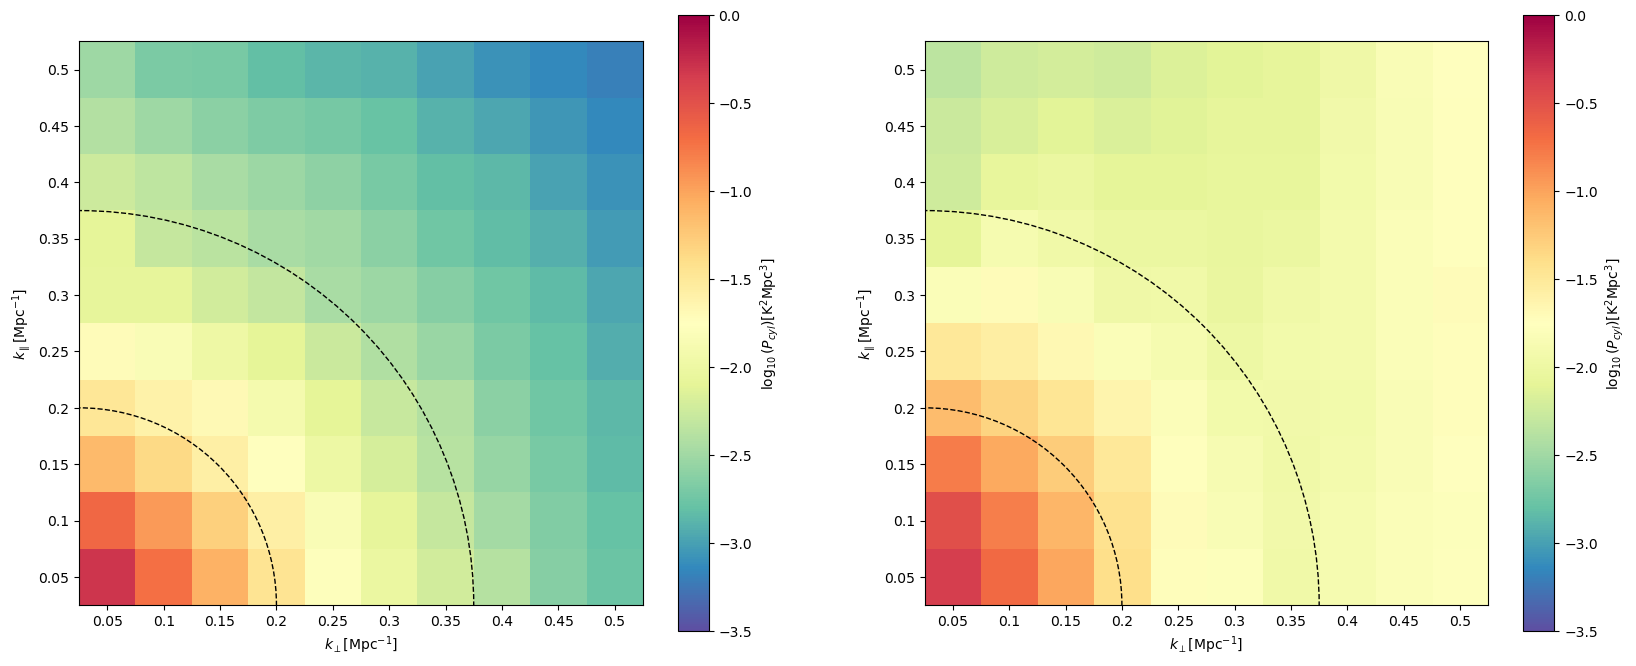

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(20,8))
plt.axes(ax[0])
plt.imshow(np.log10(truth), origin='lower', cmap='Spectral_r', vmax=0, vmin=-3.5) #note that imshow has transposed the x and y axis
plt.colorbar(label=r'$\log_{10}(P_{cyl})\mathrm{[K^{2}Mpc^{3}]}$')
plt.xlabel(r'$k_{\perp}\mathrm{[Mpc^{-1}]}$')
plt.ylabel(r'$k_{\parallel}\mathrm{[Mpc^{-1}]}$')
plt.xticks(np.arange(10),per_bins)
plt.yticks(np.arange(10),par_bins)
#plt.xlim(0,7)
#plt.ylim(0,7)
circ1 = plt.Circle((-0.5,-0.5), 3.5, fill=False, linestyle='--')
circ2 = plt.Circle((-0.5,-0.5), 7, fill=False, linestyle='--')
ax[0].add_patch(circ1)
ax[0].add_patch(circ2)

plt.axes(ax[1])
plt.imshow(np.log10(ps2d.data[:10]), origin='lower', cmap='Spectral_r', vmax=0, vmin=-3.5) #note that imshow has transposed the x and y axis
plt.colorbar(label=r'$\log_{10}(P_{cyl})\mathrm{[K^{2}Mpc^{3}]}$') 
plt.xlabel(r'$k_{\perp}\mathrm{[Mpc^{-1}]}$')
plt.ylabel(r'$k_{\parallel}\mathrm{[Mpc^{-1}]}$')
plt.xticks(np.arange(10),ps2d.k_per.round(2))
plt.yticks(np.arange(len(ps2d.k_par[:10])),ps2d.k_par[:10].round(2))
#plt.xlim(0,7)
#plt.ylim(0,12)
circ3 = plt.Circle((-0.5,-0.5), 3.5, fill=False, linestyle='--')
circ4 = plt.Circle((-0.5,-0.5), 7, fill=False, linestyle='--')
ax[1].add_patch(circ3)
ax[1].add_patch(circ4);

To finish, we will save the PS and its errors in two files following the submission format:

In [17]:
team = 'TRUTH-Foregrounds-FRIENDS'
freq_start = '166.0'
freq_end = '181.0'

In [18]:
np.savetxt(f'{team}_{freq_start}MHz-{freq_end}MHz.data', ps2d.data[:10], fmt='%.8g')
np.savetxt(f'{team}_{freq_start}MHz-{freq_end}MHz_errors.data', ps2d.err[:10], fmt='%.8g')

## Appendix

### Appendix A
Transformation to brightness temperature $B$ is done with:
$$ B = data \cdot \frac{10^{-26}\lambda^2}{2k_B\Omega} $$
where $\Omega$ is either
$$ scale factor \cdot resolution^2\; ,$$ with the $scale factor$ given as input or calculated from WSCNORMF, or 
$$ b_{maj}(rad) \cdot b_{min}(rad) \cdot \frac{\pi}{4\log(2)} \; .$$

If `use_wscnormf=True` the $scale farctor$ comes from WSCNORMF and the PSF is saved as weights.

If `use_wscnormf=False` the $scale factor$ is 1 and the data, already in K, is divided by the PSF and multiplied by $1/N_{pix}$. The PSF is saved as weights. We use this second option.

- WSCNORMF keyword: Normalization factor that was applied to the image. The factor is useful to undo the normalization for e.g. conversion to Kelvins. WSCNORMF is available since WSClean 2.

### Appendix B

The functions called by `get_ps2d()` are `get_2d_power_spectra(data_cube)` -> `get_2d_cross_power_spectra(data_cube,data_cube)` -> `get_cross_power_spectra(data_cube,data_cube)`.

The power spectrum is calculated with:
```
ps_cube = complex_conjugate(data_cube) * data_cube
ps = sum(weights * ps_cube) / sum(weights) for each bin of el
ps_err = sqrt(2 * sum(weights**2 * ps**2) / sum(weights**2))
```
Then, to obtain the 2D spectrum, another transformations and normalizations are done in the functions mentioned above.